# Introduction
This is the initial commit to decide what to do.
This notebook may estimate the length of release period and desease period.

* Data cleaning
* Estimation of release period
* Estimation of decease period
* Estimation of effective contact rate
* The number of cases
* The number of cases grouped-by infection order

In [1]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'02Mar2020 16:17'

# Deta cleaning

## Packages

In [2]:
from datetime import timedelta, date
from dateutil.relativedelta import relativedelta
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm

In [3]:
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (9, 6)

## Functions

### Plotting

In [4]:
def line_plot(df, title, ylabel="Cases", h=None, v=None, xlim=(None, None), ylim=(0, None), math_scale=True):
    """
    Show chlonological change of the data.
    """
    ax = df.plot()
    if math_scale:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
    if h is not None:
        ax.axhline(y=h, color="black", linestyle="--")
    if v is not None:
        ax.axvline(x=v, color="black", linestyle="--")
    plt.tight_layout()
    plt.show()

## Raw data

In [5]:
import os
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/coronavirusdataset/time.csv
/kaggle/input/coronavirusdataset/patient.csv
/kaggle/input/coronavirusdataset/route.csv


In [6]:
raw_patient = pd.read_csv("/kaggle/input/coronavirusdataset/patient.csv")
raw_patient.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
0,1,female,1984.0,China,filtered at airport,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
1,2,male,1964.0,Korea,filtered at airport,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
2,3,male,1966.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
3,4,male,1964.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
4,5,male,1987.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,NaN,NaN,isolated


In [7]:
raw_route = pd.read_csv("/kaggle/input/coronavirusdataset/route.csv")
raw_route.head()

,id,date,province,city,visit,latitude,longitude
0,1,2020-01-19,Incheon,Jung-gu,airport,37.460459,126.440680
1,1,2020-01-20,Incheon,Seo-gu,hospital_isolated,37.478832,126.668558
2,2,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.562143,126.801884
3,2,2020-01-23,Seoul,Jung-gu,hospital_isolated,37.567454,127.005627
4,3,2020-01-20,Incheon,Jung-gu,airport,37.460459,126.440680


## Data cleaning: raw_patient

In [8]:
raw_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4212 entries, 0 to 4211
Data columns (total 14 columns):
id                  4212 non-null int64
sex                 318 non-null object
birth_year          292 non-null float64
country             4212 non-null object
region              305 non-null object
group               76 non-null object
infection_reason    130 non-null object
infection_order     35 non-null float64
infected_by         62 non-null float64
contact_number      32 non-null float64
confirmed_date      4212 non-null object
released_date       28 non-null object
deceased_date       13 non-null object
state               4212 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 460.8+ KB


In [9]:
raw_patient.describe(include="all").fillna("-")

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
count,4212,318,292,4212,305,76,130,35,62,32,4212,28,13,4212
unique,-,2,-,3,13,6,11,-,-,-,27,15,8,3
top,-,female,-,Korea,Gyeongsangbuk-do,Shincheonji Church,contact with patient,-,-,-,2020-03-01,2020-02-19,2020-02-23,isolated
freq,-,163,-,4203,119,51,66,-,-,-,1062,4,4,4171
mean,2106.5,-,1973.18,-,-,-,-,2.25714,330.742,96.8438,-,-,-,-
std,1216.04,-,17.3366,-,-,-,-,1.35783,458.787,224.67,-,-,-,-
min,1,-,1937,-,-,-,-,1,3,0,-,-,-,-
25%,1053.75,-,1959,-,-,-,-,1,29.25,2.75,-,-,-,-
50%,2106.5,-,1972,-,-,-,-,2,126,16.5,-,-,-,-
75%,3159.25,-,1987,-,-,-,-,3,372,69.75,-,-,-,-


In [10]:
pd.DataFrame(raw_patient.isnull().sum()).T

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
0,0,3894,3920,0,3907,4136,4082,4177,4150,4180,0,4184,4199,0


In [11]:
pd.DataFrame(raw_patient["group"].value_counts()).T

,Shincheonji Church,Cheongdo Daenam Hospital,Eunpyeong St. Mary's Hospital,Pilgrimage,Myungsung church,Onchun Church
group,51,9,8,6,1,1


In [12]:
pd.DataFrame(raw_patient["infection_order"].value_counts()).T

,1.0,2.0,3.0,4.0,5.0,6.0
infection_order,13,10,6,3,2,1


In [13]:
pd.DataFrame(raw_patient["state"].value_counts()).T

,isolated,released,deceased
state,4171,28,13


In [14]:
pd.DataFrame(raw_patient["infection_reason"].value_counts()).T

,contact with patient,visit to Daegu,visit to Wuhan,pilgrimage to Israel,residence in Wuhan,visit to Thailand,contact with patient in Singapore,visit to China,visit to Cheongdo Daenam Hospital,contact with patient in Japan,visit to Vietnam
infection_reason,66,40,8,6,2,2,2,1,1,1,1


In [15]:
reason_dict = {
    "contact with patient in Singapore": "contact with patient",
    "pilgrimage to Israel": "visit to other area",
    "contact with patient in Singapore": "contact with patient",
    "residence in Wuhan": "visit to Wuhan",
    "contact with the patient": "contact with patient",
    "visit to Vietnam": "visit to other area",
    "contact with patient in Japan": "contact with patient",
    "visit to China": "visit to other area",
    "visit to Thailand": "visit to other area",
    "ccontact with patient": "contact with patient",
}
pd.DataFrame(raw_patient["infection_reason"].replace(reason_dict).value_counts()).T

,contact with patient,visit to Daegu,visit to Wuhan,visit to other area,visit to Cheongdo Daenam Hospital
infection_reason,69,40,10,10,1


**Thank you, @Colibrì**  
[Conditional probabilities and association rules](https://www.kaggle.com/colibri/conditional-probabilities-and-association-rules)

In [16]:
raw_patient["sex"].unique().tolist()

['female', 'male', nan]

In [17]:
patient_df = raw_patient.copy()
today = date.today()
date_cols = patient_df.loc[:, patient_df.columns.str.endswith("_date")].columns
# Date
for col in date_cols:
    patient_df[col] = pd.to_datetime(patient_df[col])
# Sex
# Thank you, @Colibrì
# https://www.kaggle.com/colibri/conditional-probabilities-and-association-rules
patient_df["sex"] = patient_df["sex"].replace({"female ": "female"}).fillna("-")
# Age
patient_df["age"] = patient_df["confirmed_date"].dt.year - patient_df["birth_year"]
patient_df["age"] = patient_df["age"].fillna(-1).astype(int)
# Age_bin: [0, 10), [11, 20)...
patient_df["age_bin"] = pd.cut(patient_df["age"], np.arange(0, 100, 10), include_lowest=True, right=False)
patient_df["age_bin"] = patient_df["age_bin"].cat.add_categories("-").fillna("-")
# Endpoint: censored date or closed date
patient_df["endpoint_date"] = patient_df.loc[:, [*date_cols.tolist(), "state"]].apply(
    lambda x: x[1] if x[3] == "released" else x[2] if x[3] == "deceased" else today,
    axis=1
)
patient_df["endpoint_days"] = patient_df["endpoint_date"] - patient_df["confirmed_date"]
patient_df["endpoint_days"] = patient_df["endpoint_days"].dt.days.astype(int)
# Integer
patient_df["infection_order"] = patient_df["infection_order"].fillna(-1).astype(int)
patient_df["contact_number"] = patient_df["contact_number"].fillna(0).astype(int)
# Infection reason
patient_df["infection_reason"] = patient_df["infection_reason"].fillna("-")
patient_df["infection_reason"] = patient_df["infection_reason"].replace(reason_dict)
# Fill NAs
patient_df["region"] = patient_df["region"].fillna("-")
patient_df["group"] = patient_df["group"].fillna("-")
patient_df["infected_by"] = patient_df["infected_by"].fillna(-1).astype(int)
# State
state_series = patient_df["state"]
patient_df = pd.get_dummies(patient_df, columns=["state"])
state_cols = patient_df.loc[:, patient_df.columns.str.startswith("state_")].columns
patient_df.loc[:, state_cols] = patient_df.loc[:, state_cols].astype(bool)
patient_df["state"] = state_series
# Delete/Rename columns and show the dataframe
patient_df = patient_df.drop(["birth_year"], axis=1)
patient_df = patient_df.rename(
    {"infection_reason": "reason", "infection_order": "order", "infected_by": "by"},
    axis=1
)
patient_df.head()

,id,sex,country,region,group,reason,order,by,contact_number,confirmed_date,released_date,deceased_date,age,age_bin,endpoint_date,endpoint_days,state_deceased,state_isolated,state_released,state
0,1,female,China,filtered at airport,-,visit to Wuhan,1,-1,45,2020-01-20,2020-02-06,NaT,36,"[30, 40)",2020-02-06,17,False,False,True,released
1,2,male,Korea,filtered at airport,-,visit to Wuhan,1,-1,75,2020-01-24,2020-02-05,NaT,56,"[50, 60)",2020-02-05,12,False,False,True,released
2,3,male,Korea,capital area,-,visit to Wuhan,1,-1,16,2020-01-26,2020-02-12,NaT,54,"[50, 60)",2020-02-12,17,False,False,True,released
3,4,male,Korea,capital area,-,visit to Wuhan,1,-1,95,2020-01-27,2020-02-09,NaT,56,"[50, 60)",2020-02-09,13,False,False,True,released
4,5,male,Korea,capital area,-,visit to Wuhan,1,-1,31,2020-01-30,NaT,NaT,33,"[30, 40)",2020-03-02,32,False,True,False,isolated


In [18]:
pd.DataFrame(patient_df.isnull().sum()).T

,id,sex,country,region,group,reason,order,by,contact_number,confirmed_date,released_date,deceased_date,age,age_bin,endpoint_date,endpoint_days,state_deceased,state_isolated,state_released,state
0,0,0,0,0,0,0,0,0,0,0,4184,4199,0,0,0,0,0,0,0,0


In [19]:
pd.DataFrame(patient_df["order"].value_counts()).T

,-1,1,2,3,4,5,6
order,4177,13,10,6,3,2,1


In [20]:
elapsed_days = (datetime.today() - patient_df["confirmed_date"].min()).days
elapsed_days

42

In [21]:
patient_df.pivot_table(
    index="state", columns="age_bin", values="endpoint_days", aggfunc="count"
).fillna("-").loc[["isolated", "released", "deceased"], :]

age_bin,"[0, 10)","[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)",-
state,,,,,,,,,,
isolated,2,4,53,43.0,28.0,49.0,48.0,21,3,3920
released,-,-,6,4.0,7.0,8.0,3.0,-,-,-
deceased,-,-,-,1.0,1.0,5.0,4.0,2,-,-


## Data cleaning: raw_route

In [22]:
raw_route.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 7 columns):
id           68 non-null int64
date         68 non-null object
province     68 non-null object
city         68 non-null object
visit        68 non-null object
latitude     68 non-null float64
longitude    68 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 3.8+ KB


In [23]:
raw_route.describe(include="all").fillna("-")

,id,date,province,city,visit,latitude,longitude
count,68,68,68,68,68,68,68
unique,-,15,5,17,16,-,-
top,-,2020-01-22,Gyeonggi-do,Jung-gu,hospital_isolated,-,-
freq,-,9,26,11,14,-,-
mean,8.16176,-,-,-,-,37.4285,127.03
std,4.20238,-,-,-,-,0.389759,0.581902
min,1,-,-,-,-,35.9557,126.441
25%,4.75,-,-,-,-,37.4605,126.778
50%,8,-,-,-,-,37.5248,127
75%,12,-,-,-,-,37.5896,127.051


In [24]:
pd.DataFrame(raw_route.isnull().sum()).T

,id,date,province,city,visit,latitude,longitude
0,0,0,0,0,0,0,0


In [25]:
pd.DataFrame(raw_route["visit"].value_counts()).T

,hospital_isolated,airport,restaurant,clinic,hospital,etc,train_station,hair_salon,market,movie_theater,hotel,store,office,cafe,bus_terminal,church
visit,14,10,8,6,5,4,4,3,3,3,2,2,1,1,1,1


In [26]:
route_df = raw_route.copy()
route_df["date"] = pd.to_datetime(route_df["date"])
route_df.head()

,id,date,province,city,visit,latitude,longitude
0,1,2020-01-19,Incheon,Jung-gu,airport,37.460459,126.440680
1,1,2020-01-20,Incheon,Seo-gu,hospital_isolated,37.478832,126.668558
2,2,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.562143,126.801884
3,2,2020-01-23,Seoul,Jung-gu,hospital_isolated,37.567454,127.005627
4,3,2020-01-20,Incheon,Jung-gu,airport,37.460459,126.440680


# Estimation of release period
We will estimate the release period in South Korea.

## Arrange dataset

In [27]:
cause_candidates = ["age_bin", "sex", "country", "region", "group", "reason", "order"]
release_df = patient_df.loc[patient_df["state"] == "released", [*cause_candidates, "endpoint_days"]]
release_df.head()

,age_bin,sex,country,region,group,reason,order,endpoint_days
0,"[30, 40)",female,China,filtered at airport,-,visit to Wuhan,1,17
1,"[50, 60)",male,Korea,filtered at airport,-,visit to Wuhan,1,12
2,"[50, 60)",male,Korea,capital area,-,visit to Wuhan,1,17
3,"[50, 60)",male,Korea,capital area,-,visit to Wuhan,1,13
5,"[50, 60)",male,Korea,capital area,-,contact with patient,2,20


## Find explanatory variable of release period

In [28]:
X = pd.get_dummies(release_df.drop("endpoint_days", axis=1), drop_first=True)
X = sm.add_constant(X)
y = release_df["endpoint_days"]
model = sm.OLS(y, X)
result = model.fit()
result.summary()

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          endpoint_days   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     2.511
Date:                Mon, 02 Mar 2020   Prob (F-statistic):             0.0632
Time:                        16:17:07   Log-Likelihood:                -66.068
No. Observations:                  28   AIC:                             166.1
Df Residuals:                      11   BIC:                             188.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -1.8850      5.383     -0.350      0.733     -13.733       9.963
order                          -7.5072      3.173     -2.366      0.037     -14.492      -0.523
age_bin_[10, 20)             -2.59e-14   1.01e-14     -2.563      0.026   -4.81e-14   -3.66e-15
age_bin_[20, 30)               -0.0357      2.318     -0.015      0.988      -5.137       5.065
age_bin_[30, 40)               -8.7067      2.772     -3.142      0.009     -14.807      -2.607
age_bin_[40, 50)                2.0606      2.228      0.925      0.375      -2.842       6.964
age_bin_[50, 60)               -1.2710      2.114     -0.601      0.560      -5.924       3.382
age_bin_[60, 70)                6.0678      4.067      1.492      0.164      -2.883      15.019
age_bin_[70, 80)             1.401e-14   4.58e-15      3.059      0.011    3.93e-15    2.41e-14
age_bin_[80, 90)            -1.929e-15   9.97e-16     -1.934      0.079   -4.12e-15    2.66e-16
age_bin_-                   -9.612e-15   3.94e-15     -2.442      0.033   -1.83e-14   -9.49e-16
sex_male                       -6.8945      2.629     -2.623      0.024     -12.680      -1.109
country_Korea                   3.6488      3.096      1.178      0.263      -3.166      10.463
region_Daegu                -4.441e-15      5.780  -7.68e-16      1.000     -12.721      12.721
region_Gwangju                 10.1845      5.173      1.969      0.075      -1.201      21.570
region_Gyeongsangbuk-do         3.5629      6.751      0.528      0.608     -11.296      18.422
region_Jeollabuk-do             3.3260      6.739      0.494      0.631     -11.507      18.159
region_capital area            21.6891      6.064      3.577      0.004       8.343      35.036
region_filtered at airport     23.9892      6.723      3.568      0.004       9.192      38.787
group_Shincheonji Church      -25.3398      9.751     -2.599      0.025     -46.802      -3.878
reason_contact with patient    17.0010      7.103      2.393      0.036       1.367      32.635
reason_visit to Wuhan           8.3496      4.018      2.078      0.062      -0.493      17.192
reason_visit to other area      8.4984      6.078      1.398      0.190      -4.880      21.877
==============================================================================
Omnibus:                        3.959   Durbin-Watson:                   2.553
Prob(Omnibus):                  0.138   Jarque-Bera (JB):                2.459
Skew:                          -0.420   Prob(JB):                        0.292
Kurtosis:                       4.184   Cond. No.                     2.97e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The sm

In [29]:
df = pd.DataFrame(result.pvalues.sort_values()).reset_index()
df.columns = ["cause", "pvalue"]
df = df.loc[df["pvalue"] < 0.05, :]
release_causes = df["cause"].tolist()
df

,cause,pvalue
0,region_capital area,0.004343
1,region_filtered at airport,0.004409
2,"age_bin_[30, 40)",0.009383
3,"age_bin_[70, 80)",0.010880
4,sex_male,0.023711
5,group_Shincheonji Church,0.024753
6,"age_bin_[10, 20)",0.026372
7,age_bin_-,0.032695
8,reason_contact with patient,0.035643
9,order,0.037433


In [30]:
X = pd.get_dummies(release_df, drop_first=True)
X = sm.add_constant(X)[release_causes]
y = release_df["endpoint_days"]
model = sm.OLS(y, X)
result = model.fit()
result.summary()

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:1362: RuntimeWarning:

invalid value encountered in true_divide

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          endpoint_days   R-squared (uncentered):                   0.855
Model:                            OLS   Adj. R-squared (uncentered):              0.807
Method:                 Least Squares   F-statistic:                              17.74
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                    1.69e-07
Time:                        16:17:07   Log-Likelihood:                         -90.447
No. Observations:                  28   AIC:                                      194.9
Df Residuals:                      21   BIC:                                      204.2
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
region_capital area            13.7405      4.331      3.172      0.005       4.733      22.748
region_filtered at airport     19.3451      5.645      3.427      0.003       7.606      31.084
age_bin_[30, 40)               -7.8123      4.280     -1.825      0.082     -16.714       1.089
age_bin_[70, 80)            -1.751e-15   8.19e-16     -2.139      0.044   -3.45e-15   -4.83e-17
sex_male                        0.0662      2.891      0.023      0.982      -5.946       6.078
group_Shincheonji Church        3.0111     10.700      0.281      0.781     -19.241      25.263
age_bin_[10, 20)                     0          0        nan        nan           0           0
age_bin_-                            0          0        nan        nan           0           0
reason_contact with patient     4.5473      5.681      0.800      0.432      -7.268      16.362
order                           0.5583      2.683      0.208      0.837      -5.021       6.138
==============================================================================
Omnibus:                        0.008   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.996   Jarque-Bera (JB):                0.150
Skew:                          -0.035   Prob(JB):                        0.928
Kurtosis:                       2.649   Cond. No.                     4.91e+33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.14e-66. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [31]:
df = pd.DataFrame(result.pvalues.sort_values()).reset_index()
df.columns = ["cause", "pvalue"]
df = df.loc[df["pvalue"] < 0.05, :]
release_causes = df["cause"].tolist()
df

,cause,pvalue
0,region_filtered at airport,0.002532
1,region_capital area,0.004589
2,"age_bin_[70, 80)",0.044383


In [32]:
X = pd.get_dummies(release_df, drop_first=True)
X = sm.add_constant(X)[release_causes]
y = release_df["endpoint_days"]
model = sm.OLS(y, X)
result = model.fit()
result.summary()

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning:

divide by zero encountered in double_scalars



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          endpoint_days   R-squared (uncentered):                   0.808
Model:                            OLS   Adj. R-squared (uncentered):              0.793
Method:                 Least Squares   F-statistic:                              54.63
Date:                Mon, 02 Mar 2020   Prob (F-statistic):                    4.90e-10
Time:                        16:17:07   Log-Likelihood:                         -94.426
No. Observations:                  28   AIC:                                      192.9
Df Residuals:                      26   BIC:                                      195.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
region_filtered at airport    18.0000      3.659      4.919      0.000      10.478      25.522
region_capital area           16.8750      1.830      9.223      0.000      13.114      20.636
age_bin_[70, 80)                    0          0        nan        nan           0           0
==============================================================================
Omnibus:                        0.363   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.834   Jarque-Bera (JB):                0.505
Skew:                          -0.212   Prob(JB):                        0.777
Kurtosis:                       2.496   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [33]:
release_df.pivot_table(
    index="age_bin", columns="region", values="endpoint_days", aggfunc=["median", "count"]
).fillna("-")

median                                                           \
region        - Daegu Gwangju Gyeongsangbuk-do Jeollabuk-do capital area   
age_bin                                                                    
[20, 30)      -     -      14                -            -         16.0   
[30, 40)      -     -       -                -            -          7.0   
[40, 50)      -     -      12                8            -         18.0   
[50, 60)      8     8       -                -            -         19.0   
[60, 70)      -     7       -                -           12         24.0   

                             count                                 \
region   filtered at airport     - Daegu Gwangju Gyeongsangbuk-do   
age_bin                                                             
[20, 30)                21.5     -     -       1                -   
[30, 40)                  17     -     -       -                -   
[40, 50)                   -     -     -       2                1   
[50, 60)                  12     1     1       -                -   
[60, 70)                   -     -     1       -                -   

                                                        
region   Jeollabuk-do capital area filtered at airport  
age_bin                                                 
[20, 30)            -          3.0                   2  
[30, 40)            -          3.0                   1  
[40, 50)            -          4.0                   -  
[50, 60)            -          5.0                   1  
[60, 70)            1          1.0                   -

## Mean/Median value of release period
Release period may depends on age and region, but the numbers of cases are small. We will assume that the median value of all reported cases can be applied to all people in South Korea.

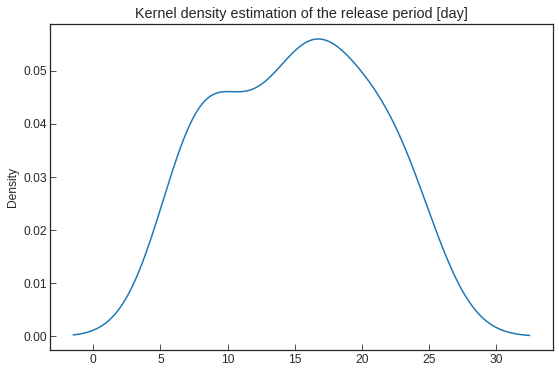

In [34]:
release_df["endpoint_days"].plot.kde()
plt.title("Kernel density estimation of the release period [day]")
plt.show()

In [35]:
pd.DataFrame(release_df["endpoint_days"].describe()).T

,count,mean,std,min,25%,50%,75%,max
endpoint_days,28.0,15.107143,5.626256,7.0,9.75,16.0,19.25,24.0


# Estimation of release period
We will estimate the release period in South Korea.

## Arrange dataset

In [36]:
cause_candidates = ["age_bin", "sex", "country", "region", "group", "reason", "order"]
decease_df = patient_df.loc[patient_df["state"] == "deceased", [*cause_candidates, "endpoint_days"]]
decease_df.head()

,age_bin,sex,country,region,group,reason,order,endpoint_days
37,"[50, 60)",female,Korea,Daegu,-,-,-1,5
53,"[50, 60)",male,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,-,-1,4
54,"[50, 60)",male,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,-,-1,4
102,"[60, 70)",male,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,-,-1,-1
106,"[60, 70)",male,Korea,Gyeongsangbuk-do,Cheongdo Daenam Hospital,-,-1,3


## Mean/Median value of decease period

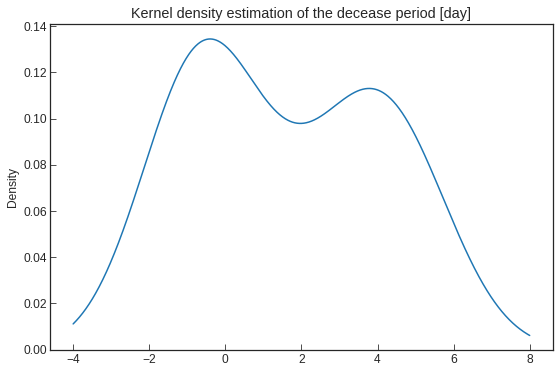

In [37]:
decease_df["endpoint_days"].plot.kde()
plt.title("Kernel density estimation of the decease period [day]")
plt.show()

In [38]:
pd.DataFrame(decease_df["endpoint_days"].describe()).T

,count,mean,std,min,25%,50%,75%,max
endpoint_days,13.0,1.615385,2.433737,-1.0,-1.0,1.0,4.0,5.0


# Estimation of effective contact rate

In [39]:
cols = ["id", "order", "by", "contact_number", "state"]
contact_df = patient_df.loc[:, cols]
contact_df.sample(5).drop("id", axis=1).reset_index(drop=True)

,order,by,contact_number,state
0,-1,-1,0,isolated
1,-1,-1,0,isolated
2,-1,-1,0,isolated
3,-1,-1,0,isolated
4,-1,-1,0,released


In [40]:
effect_dict = contact_df[["id", "by"]].groupby("by").count().to_dict(orient="index")
contact_df["effect_number"] = contact_df["id"].apply(
    lambda x: effect_dict[x]["id"] if x in effect_dict.keys() else 0
)
contact_df["effective_contact_rate"] = contact_df["effect_number"] / contact_df["contact_number"]
contact_df.loc[~contact_df["effective_contact_rate"].isna(), :].sample(5).drop("id", axis=1).reset_index(drop=True)

,order,by,contact_number,state,effect_number,effective_contact_rate
0,1,-1,31,isolated,1,0.032258
1,2,-1,68,released,0,0.000000
2,-1,-1,0,isolated,1,inf
3,-1,-1,0,isolated,3,inf
4,-1,113,0,isolated,2,inf


In [41]:
contact_df.loc[contact_df["contact_number"] < contact_df["effect_number"], :].drop(
    "id", axis=1
).reset_index(drop=True)

,order,by,contact_number,state,effect_number,effective_contact_rate
0,3,6,0,isolated,3,inf
1,-1,-1,0,isolated,1,inf
2,-1,-1,0,isolated,3,inf
3,4,83,0,isolated,1,inf
4,-1,-1,0,isolated,1,inf
5,-1,126,0,isolated,1,inf
6,-1,-1,0,isolated,1,inf
7,-1,-1,0,isolated,1,inf
8,-1,113,0,isolated,2,inf
9,-1,-1,0,isolated,2,inf


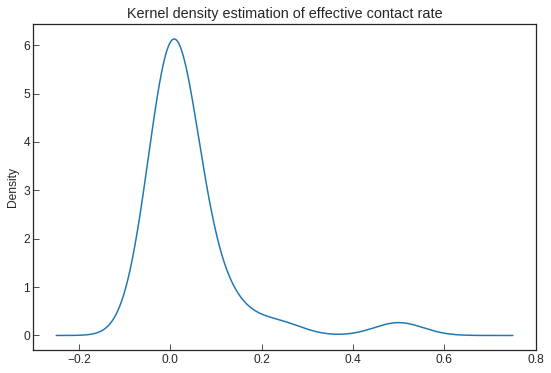

In [42]:
contact_df.replace(np.inf,np.nan).dropna()["effective_contact_rate"].plot.kde()
plt.title("Kernel density estimation of effective contact rate")
plt.show()

In [43]:
pd.DataFrame(contact_df.replace(np.inf,np.nan).dropna()["effective_contact_rate"].describe()).T

,count,mean,std,min,25%,50%,75%,max
effective_contact_rate,28.0,0.043001,0.10443,0.0,0.0,0.0,0.033453,0.5


# The number of cases

In [44]:
count_df = pd.DataFrame(
    {
        "Confirmed": patient_df.groupby("confirmed_date").count().iloc[:, 0],
        "Deceased": patient_df.groupby("deceased_date").count().iloc[:, 0],
        "Released": patient_df.groupby("released_date").count().iloc[:, 0]
    }
)
count_df = count_df.asfreq("D").fillna(0).cumsum().astype(int)
count_df["Currently"] = count_df["Confirmed"] - count_df["Deceased"] - count_df["Released"]
count_df.tail()

,Confirmed,Deceased,Released,Currently
2020-02-26,1261,12,23,1226
2020-02-27,1766,13,25,1728
2020-02-28,2337,13,26,2298
2020-02-29,3150,13,28,3109
2020-03-01,4212,13,28,4171


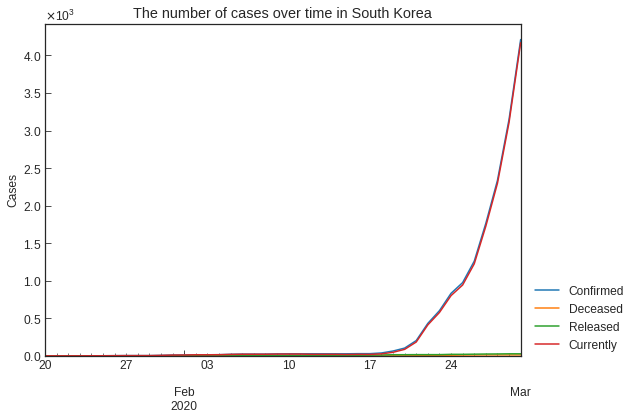

In [45]:
line_plot(count_df, "The number of cases over time in South Korea")

## The number of cases grouped-by infection order

In [46]:
def number_groupby_order(patient_df, date_name="confirmed_date"):
    """
    Calculate the cummurative number of confirmed/deseased/released cases for each infection order.
    @patient_df <pd.DataFrame>
    @date_name <str>: confirmed_date etc.
    @return <pd.DataFrame>:
        - index: date (max: the max date of the patient_df)
        - column: infection order
        - value: cummurative number of the cases
    """
    df = patient_df.pivot_table(
        index=date_name, columns="order", values="id", aggfunc="count"
    ).asfreq("D")
    date_range = pd.date_range(
        start=patient_df["endpoint_date"].min(),
        end=patient_df["endpoint_date"].max(),
        freq="D"
    )
    for date_value in date_range:
        if date_value not in df.index:
            df.loc[date_value, :] = 0
    df = df.fillna(0).astype(int).cumsum()
    return df

## Confirmed cases

In [47]:
confirmed_order_df = number_groupby_order(patient_df, date_name="confirmed_date")
confirmed_order_df.tail()

order,-1,1,2,3,4,5,6
confirmed_date,,,,,,,
2020-02-27,1731,13,10,6,3,2,1
2020-02-28,2302,13,10,6,3,2,1
2020-02-29,3115,13,10,6,3,2,1
2020-03-01,4177,13,10,6,3,2,1
2020-03-02,4177,13,10,6,3,2,1


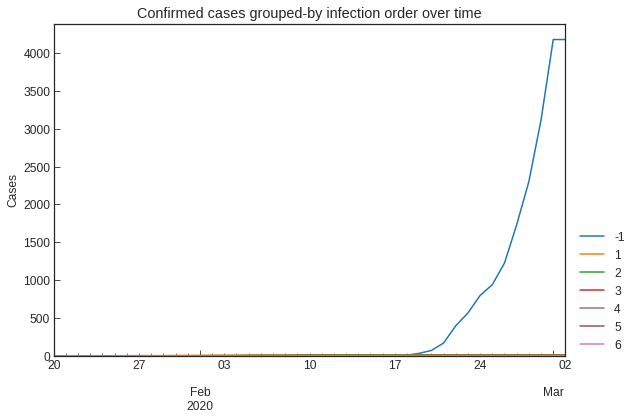

In [48]:
line_plot(confirmed_order_df, "Confirmed cases grouped-by infection order over time", math_scale=False)

## Deceased cases

In [49]:
deceased_order_df = number_groupby_order(patient_df, date_name="deceased_date")
deceased_order_df.tail()

order,-1
deceased_date,
2020-02-18,13
2020-02-28,13
2020-02-29,13
2020-03-01,13
2020-03-02,13


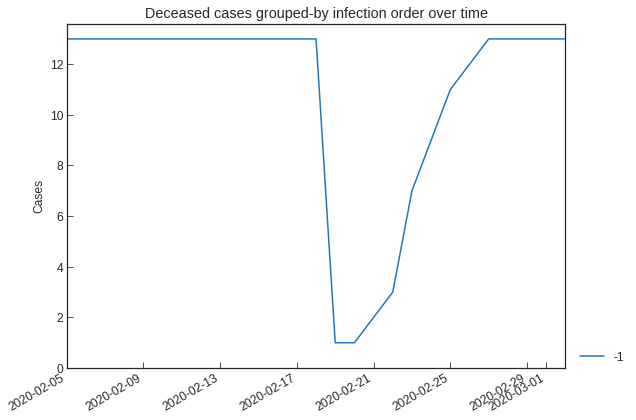

In [50]:
line_plot(deceased_order_df, "Deceased cases grouped-by infection order over time", math_scale=False)

# Released cases

In [51]:
released_order_df = number_groupby_order(patient_df, date_name="released_date")
released_order_df.tail()

order,-1,1,2,3
released_date,,,,
2020-02-27,3,9,9,4
2020-02-28,4,9,9,4
2020-02-29,4,10,9,5
2020-03-01,4,10,9,5
2020-03-02,4,10,9,5


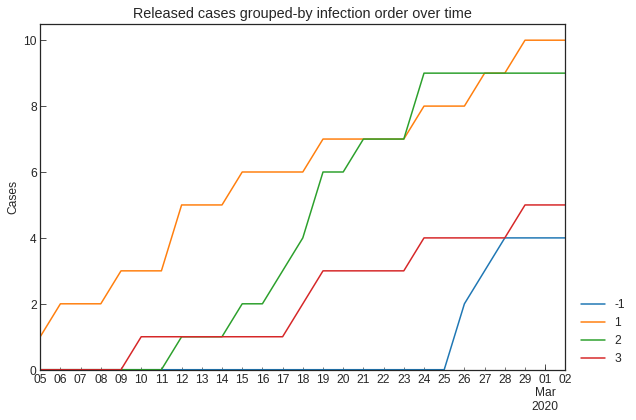

In [52]:
line_plot(released_order_df, "Released cases grouped-by infection order over time", math_scale=False)

## Currently infected cases

In [53]:
currently_order_df = confirmed_order_df.sub(deceased_order_df, fill_value=0)
currently_order_df = currently_order_df.sub(released_order_df, fill_value=0).fillna(0).astype(int)
currently_order_df.tail()

order,-1,1,2,3,4,5,6
2020-02-27,1715,4,1,2,3,2,1
2020-02-28,2285,4,1,2,3,2,1
2020-02-29,3098,3,1,1,3,2,1
2020-03-01,4160,3,1,1,3,2,1
2020-03-02,4160,3,1,1,3,2,1


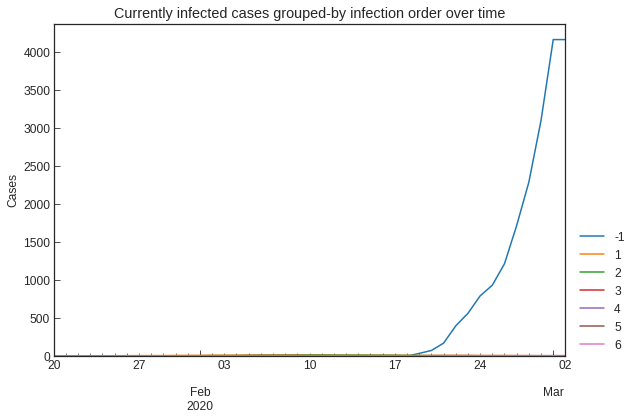

In [54]:
line_plot(currently_order_df, "Currently infected cases grouped-by infection order over time", math_scale=False)